# Code for Fig. SM 1-3

In [34]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from matplotlib import cm
from scipy.interpolate import interp1d

from general_functions import compute_energies, dos_general, plot_band_structure

To compare the band structure for our system of dipoles in a square lattice, with the results obtained for a tight binding (TB) model, we focus on the isofrequency for the $\mathbf{k}=X$ point. In the TB model the isofrequency is a 45º tilted square, with the corners in the X point. To quantify the similarity we propose the parameter

\begin{equation}
    \Delta = \int_0^{\pi/d} dk_x [(-k_x + \pi/d) - \tilde{k}_y(k_x)]^2,
\end{equation}

with $\omega(k_x, \tilde{k}_y) = \omega_{\mathbf{k}=X}$.

## Compute all band structures

In [36]:
polarizations = [np.array([[0, 1, 0]]).T]  # Polarization of lattice

d = 1  # Lattice constant

aho = 0.1 * d  # Renormalization parameter

nmax = 9  # Number of reciprocal lattice in the summatory

# Reciprocal lattice vectors
b1 = 2 * np.pi / d * np.array([1, 0])
b2 = 2 * np.pi / d * np.array([0, 1])

A = d ** 2  # Area of unit cell in real space

# Symmatric points
Gamma = [0, 0]  # 0
M = [np.pi / d, np.pi / d]  # 1
X = [np.pi / d, 0]  # 2
Y = [0, np.pi / d]  # 3
order = [1, 0, 2, 1]  # Order of the symmetric points

points = [Gamma, M, X, Y]
names = [r'$\Gamma$', r'$M$', r'$X$', r'$Y$']

points_label = []
points_site = []

# Sort the symmetric points in the desired order
for i in order:
    points_label.append(names[i])
    points_site.append(points[i])

In [37]:
n = 801  # Number of momentum to evalueate in each direction (total sites is N = n²)
k_x = (np.arange(-n // 2, n // 2) + 1) / (n // 2) * np.pi / d
k_x, k_y = [x.flatten() for x in np.meshgrid(k_x, k_x)]

k = np.vstack((k_x, k_y)).transpose()  # Momentum at which compute the bands

energy_TB = -2 * (np.cos(k_x) + np.cos(k_y)).reshape((n, n))

In [40]:
n_lambda = 100
lambda0_vec = d / np.linspace(0.1, 0.4, n_lambda)  # Wave-lenght of transition
k0_vec = 2 * np.pi / lambda0_vec

pbar = tqdm(range(n_lambda), desc='Computing band structures')
results = Parallel(n_jobs=6, backend='multiprocessing')(
    delayed(compute_energies)(b1, b2, A, nmax,
                              k0_vec[i], aho, k, polarizations=polarizations) for i in pbar)

Computing band structures:   0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
J = np.zeros((n_lambda, n, n))
energy_X = np.zeros(n_lambda)

DoS = [None] * n_lambda
DoS_X = np.zeros(n_lambda)

limit_inf = -20
limit_sup = 20

for i in range(n_lambda):
    J[i] = results[i][0].reshape((n, n))
    energy_X[i] = J[i][n // 2, -1]
    
    energy, DoS_temp = dos_general(J[i], min_E=limit_inf, max_E=np.max(J[i]) * 1.1, args=[0.1])
    DoS[i] = DoS_temp
    
    temp = np.abs(energy_X[i] - energy)
    index = np.argmin(temp)
    DoS_X[i] = DoS[i][index]

In [42]:
band_light = np.zeros((2, n_lambda))
K = np.sqrt(k_x ** 2 + k_y ** 2).reshape((n, n))

for i in range (n_lambda):
    k0 = 2 * np.pi / lambda0_vec[i]
    
    # Energies inside the light cone
    inside = np.where(K < k0)
    
    J_temp = J[i][inside]
    
    # Limits of the energies inside the light cone
    band_light[0, i] = np.min(J_temp)
    band_light[1, i] = np.max(J_temp)

## Color maps

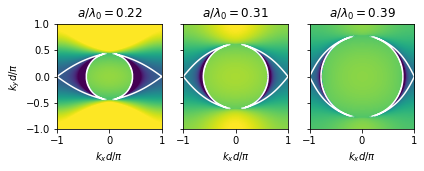

In [44]:
lambda_targets = [1 / 0.22, 1 / 0.31, 1 / 0.39]
indices = [np.argmin(np.abs(lambda_target - lambda0_vec) ** 2) for lambda_target in lambda_targets]

fig, axs = plt.subplots(1, len(lambda_targets), sharey=True, sharex=True)

limit_inf = -2
limit_sup = 1.5

for i in range(len(indices)):
    J_plot = J[indices[i]]
    ax = axs[i]
    im = ax.imshow(J_plot, extent=(-1, 1, -1, 1), vmin=limit_inf, vmax=limit_sup, origin='lower')
    contours = ax.contour(k_x.reshape((n, n)) / np.pi, k_y.reshape((n, n)) / np.pi, J_plot,
                                     [J_plot[n // 2, -1]], colors='w', linewidths=1.5, linestyles='-')
    ax.set_title(r'$a/\lambda_0 = {:.2f}$'.format(1 / lambda0_vec[indices[i]]))
axs[0].set_ylabel(r'$k_y d / \pi$')
for ax in axs:
    ax.set_xlabel(r'$k_x d / \pi$')    

fig.tight_layout()

## Optimal distance

In [45]:
fig, ax = plt.subplots()

x, y = [], []

cs = ax.contour(k_y.reshape((n, n)) / np.pi * d, k_x.reshape((n, n)) / np.pi * d,
                energy_TB, [0], colors=['white'], linestyles='--', linewidths =0.7)

p = cs.collections[0].get_paths()[0]
v = p.vertices
x.append(v[:,0])
y.append(v[:,1])

pbar = tqdm(total=n_lambda)
x_vec = np.linspace(-1, 1, n)

# Collect the isofrecuencies for each value of the optical transition
for i in range(n_lambda):
    ax.clear()
    
    J_plot = J[i]
    cs = ax.contour(x_vec, x_vec, J_plot, [J_plot[n // 2, 0]],
                    colors=['white'], linestyles='--', linewidths=0.7)
    
    p = cs.collections[0].get_paths()[0]
    v = p.vertices
    x_temp = v[:,0]
    y_temp = v[:,1]
    
    # Only focuss on the upper left quadrant
    x_temp[np.where(x_temp > 0)] *= -1
    
    mask = np.where(y_temp >= 0)
    x_temp = x_temp[mask]
    y_temp = y_temp[mask]
    
    mask = np.where(x_temp <= -0.5)
    x_temp = x_temp[mask]
    y_temp = y_temp[mask]
    
    x.append(x_temp)
    y.append(y_temp)
    
    pbar.update()
pbar.close()
ax.clear()
plt.close(fig)

  0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
error = np.ones(len(x) - 1) * np.nan
n_step = 1000
target = lambda x: x + 1

errors = []
window = 10
tolerance = 0.1

for i in range(1, len(x)):
    x_temp = x[i]
    y_temp = y[i]
    
    try:
        index_cut = 0
        for j in range(len(y_temp) - window):
            if (y_temp[j] > y_temp[j + window]):
                index_cut = j
                break
        
        # Interpolate the isofrequency to increase the number of points
        # Some errors can raise when duplicate x points exhist due to the method
        # used for the extraction of the isofrequencies.
        
        func = interp1d(x_temp[index_cut:], y_temp[index_cut:], kind='cubic')
        x_test = np.linspace(min(x_temp), max(x_temp), n_step)
        error[i - 1] = np.sqrt(np.sum((func(x_test) - target(x_test)) ** 2))
        
    except:
        errors.append(i)

Minimum error with lambda/a = 0.3060606060606061


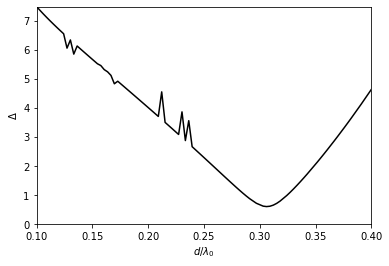

In [47]:
fig, ax = plt.subplots()

ax.plot(1 / lambda0_vec, error, 'k')

ax.set_xlim(min(1 / lambda0_vec), max(1 / lambda0_vec))
ax.set_ylim(0, max(error))

ax.set_xlabel(r'$d/\lambda_0$')
ax.set_ylabel(r'$\Delta$')

index_min = np.nanargmin(error)
print('Minimum error with d/lambda = {}'.format(1 / lambda0_vec[index_min]))

## Van Hove singularity

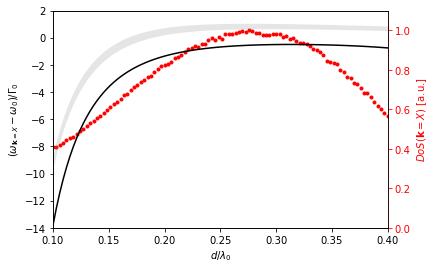

In [50]:
fig, ax = plt.subplots()

ax.plot(1 / lambda0_vec, energy_X, 'k')
ax.set_xlabel(r'$d/\lambda_0$')
ax.set_ylabel(r'$(\omega_{\mathbf{k}=X}-\omega_0)/\Gamma_0$')
ax.set_ylim(-14, 2)

ax.fill_between(1 / lambda0_vec, band_light[0], band_light[1],
                     color='grey', lw=0, alpha=0.2)

ax2 = ax.twinx()
ax2.plot(1 / lambda0_vec, DoS_X / np.max(DoS_X), 'r.')

ax2.set_ylabel(r'$DoS(\mathbf{k} = X)$ [a.u.]')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r', which='both')
ax2.yaxis.label.set_color('r')

ax.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax.set_xlim(min(1 / lambda0_vec), max(1 / lambda0_vec))
ax2.set_ylim([0, 1.1]);